In [6]:
from collections import defaultdict
from glob import glob
from random import choice, sample

import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, LayerNormalization, BatchNormalization, Layer, Conv2D, InputSpec
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

from tf2_keras_vggface.utils import preprocess_input
from tf2_keras_vggface.vggface import VGGFace

import os
import functools
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
# Hyperparameters
BASE_MODEL = 'vgg16'
INPUT_SHAPE = (224, 224,)

# Modify paths as per your method of saving them
BASE_PATH = "/root/KinshipRecognition"
TRAIN_FILE_PATH = f"{BASE_PATH}/data/aug_train_ds.csv"
TRAIN_FOLDERS_PATH = f"{BASE_PATH}/data/train/train-faces/"

In [8]:
def read_img(path, input_shape):
    img = cv2.imread(path, -1)
    img = cv2.resize(img, input_shape)
    img = cv2.normalize(img,  np.zeros(img.shape[:2]), 0, 255, cv2.NORM_MINMAX)
    return np.array(img).astype(np.float)

In [9]:
# Load model
backbone = VGGFace(model=BASE_MODEL, include_top=False)
backbone.summary()


Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, None, None, 64)    1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, None, None, 64)    36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, None, None, 64)    0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, None, None, 128)   73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, None, None, 128)   147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, None, None, 128) 

In [10]:
# Load sample image
sample_img = glob(F"{TRAIN_FOLDERS_PATH}/*/*/*")[1250]
sample_img = read_img(sample_img, INPUT_SHAPE)
sample_img = tf.Variable(np.expand_dims(sample_img, axis=0), dtype=tf.float32, trainable=False) 


In [12]:
backbone(sample_img).shape

TensorShape([1, 7, 7, 512])

(1, 28, 28, 512)


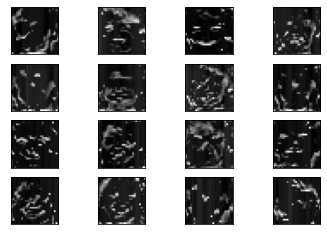

In [42]:
# Output for layer 1
# inputs = Input(shape=INPUT_SHAPE + (3,))
# seq = Sequential()
# seq.add(inputs)
# for l in backbone.layers[:12]:
#     seq.add(l)
# out = seq(sample_img)
print(out.shape)
ix = 1
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(out[0, :, :, 48+ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [18]:
class SelfAttentionKernel(Layer):
    
    def __init__(self, units, kernel_dim2D, value_dim, output_dim=None,
                 kernel_initializer="glorot_uniform", kernel_regularizer='l2', **kwargs):
    
        super(SelfAttentionKernel, self).__init__(**kwargs)
        
        self.units = units # Same as num_output_channels
        self.value_dim = value_dim
        assert len(kernel_dim2D) == 2
        self.kernel_dim2D = kernel_dim2D
        self.kernel_len = kernel_dim2D[0] * kernel_dim2D[1]
        self.output_dim = output_dim if output_dim else kernel_len
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer = kernel_regularizer
        
        self.key_w = None
        self.query_w = None
        self.value_w = None
        self.scale = self.value_dim ** -0.5
        
    def build(self, input_shape):
        
        self.query_w = self.add_weight(shape=(self.units, self.value_dim, self.output_dim),
                                       initializer=self.kernel_initializer,
                                       regularizer=self.kernel_regularizer,
                                       trainable=True)
        self.key_w = self.add_weight(shape=(self.units, self.value_dim, self.output_dim),
                                     initializer=self.kernel_initializer,
                                     regularizer=self.kernel_regularizer,
                                     trainable=True)
        self.value_w = self.add_weight(shape=(self.units, self.value_dim, self.kernel_len),
                                     initializer=self.kernel_initializer,
                                     regularizer=self.kernel_regularizer,
                                     trainable=True)

    def call(self, value):    
        
        # Query, values, and keys are of shape=(N, h, w, c)
        
        N, h, w, c = value.shape
        value = tf.transpose(value, perm=(0, 3, 1, 2))
        value = tf.reshape(value, shape=(N, c, h*w))
        
        qW = tf.matmul(tf.expand_dims(value, 1), self.query_w)
        kW = tf.matmul(tf.expand_dims(value, 1), self.key_w)
        dot = tf.matmul(qW, tf.transpose(kW, perm=(0, 1, 3, 2,)))
        attn_w = tf.nn.softmax(dot * self.scale)
        vW = tf.matmul(tf.expand_dims(value, 1), self.value_w)
        flat_kernel = tf.einsum('ijkl, ijlm -> ijkm', attn_w, vW)
        kernel = tf.reshape(flat_kernel, shape=(N, self.units, c, self.kernel_dim2D[0], self.kernel_dim2D[1]))
        kernel = tf.transpose(kernel, perm=(0, 3, 4, 2, 1))
        return kernel
    


In [19]:
from tensorflow.python.ops import nn_ops
import functools

class CrossAttentionConv2D(Layer):
    def __init__(self, strides=[1, 1, 1, 1], padding='VALID',
                 data_format=None, dilations=None, **kwargs):

        super(CrossAttentionConv2D, self).__init__(**kwargs)
        
        self.strides = strides
        self.padding = padding
        self.data_format = data_format
        self.dilations = dilations
        
    def call(self, input_img, kernel):
        
        # Match batch and channels dimensions
        assert kernel.shape[0] == input_img.shape[0]
        assert kernel.shape[3] == input_img.shape[3]

        n, h, w, in_c = input_img.shape
        _, k_h, k_w, _, out_c = kernel.shape
        
        # Kernel shape -> (h, w, n*in_c, out_c)
        kernel = tf.transpose(kernel, perm=(1, 2, 0, 3, 4))
        kernel = tf.reshape(kernel, shape=(k_h, k_w, n*in_c, out_c))        
        # Inputs shape -> (h, w, n*in_c)
        input_img = tf.transpose(input_img, perm=(1, 2, 0, 3))
        input_img = tf.reshape(input_img, shape=(1, h, w, n*in_c))        
        # Do depth-wise convolution
        conv_out = tf.nn.depthwise_conv2d(input_img, kernel, self.strides, self.padding, self.dilations)
        # Output shape -> (n, out_h, out_w, out_c)
        _, out_h, out_w = conv_out.shape[:3]
        conv_out = tf.reshape(conv_out, shape=(out_h, out_w, n, in_c, out_c))
        conv_out = tf.transpose(conv_out, perm=(2, 0, 1, 3, 4))
        conv_out = tf.reduce_sum(conv_out, axis=3)
        
        return conv_out

In [120]:
class ConvTransformer(Layer):

    def __init__(self, units, value_dim, kernel_dim2D, out_dim2D, out_channels=None, 
                 strides=[1, 1, 1, 1], padding='VALID', dense_config=None,
                 kernel_initializer="glorot_uniform", kernel_regularizer='l2',
                 data_format=None, dilations=None, **kwargs):
        
        # value_dim = H*W
        
        super(ConvTransformer, self).__init__(**kwargs)
        self.value_dim = value_dim
        self.out_dim2D = out_dim2D
        
        self.norm = LayerNormalization(axis=[0, 1], epsilon=.0001, center=False, scale=False)
        self.self_attn = SelfAttentionKernel(out_channels, (3, 3), value_dim, output_dim=out_channels)
        self.cross_conv = CrossAttentionConv2D(strides=[1, 1, 1, 1], padding=padding)
        self.dense_block = Sequential()
        if dense_config:
            for i in dense_config:
                self.dense_block.add(Dense(i[0], activation=i[1]))
        self.dense_block.add(Dense(out_dim2D[0] * out_dim2D[1], activation='linear'))
        
    def call(self, x1, x2):        
        
        assert x1.shape == x2.shape
        
        N, h, w, in_c = x1.shape
        # Normalize input images by (H,W)
        x1 = self.norm(x1)
        x2 = self.norm(x2)
        # Output from cross attention
        conv_x1 = self.norm(self.cross_conv(x2, self.self_attn(x1)))
        conv_x2 = self.norm(self.cross_conv(x1, self.self_attn(x2)))
        
        N, h, w, out_c = conv_x1.shape
        # Flatten (H, W) dimension
        conv_x1 = tf.transpose(conv_x1, perm=(0, 3, 1, 2))
        conv_x2 = tf.transpose(conv_x2, perm=(0, 3, 1, 2))
        conv_x1 = tf.reshape(conv_x1, shape=(N, out_c, h*w))
        conv_x2 = tf.reshape(conv_x2, shape=(N, out_c, h*w))
        # Feed into dense network
        out_x1 = self.dense_block(conv_x1)
        out_x2 = self.dense_block(conv_x2)
        # Reshape to shape of image.
        out_x1 = tf.reshape(out_x1, shape=(N, out_c, self.out_dim2D[0], self.out_dim2D[1]))
        out_x2 = tf.reshape(out_x2, shape=(N, out_c, self.out_dim2D[0], self.out_dim2D[1]))
        out_x1 = tf.transpose(out_x1, perm=(0, 2, 3, 1))        
        out_x2 = tf.transpose(out_x2, perm=(0, 2, 3, 1))
        out_x1 = self.norm(out_x1)
        out_x2 = self.norm(out_x2)
        
        return out_x1, out_x2

In [121]:
x1 = glob(F"{TRAIN_FOLDERS_PATH}/*/*/*")[1250]
x1 = read_img(x1, INPUT_SHAPE)
x1 = tf.Variable(np.expand_dims(x1, axis=0), dtype=tf.float32, trainable=False) 
x1 = backbone(x1)
x2 = glob(F"{TRAIN_FOLDERS_PATH}/*/*/*")[1251]
x2 = read_img(x2, INPUT_SHAPE)
x2 = tf.Variable(np.expand_dims(x2, axis=0), dtype=tf.float32, trainable=False) 
x2 = backbone(x2)

In [122]:
x1.shape

TensorShape([1, 7, 7, 512])

In [123]:
ct = ConvTransformer(256, 49, (2, 2), (4, 4), out_channels=256, 
                 strides=[1, 1, 1, 1], padding='VALID', dense_config=((256, 'relu',),))

In [124]:
out_x1, out_x2 = ct(x1, x2)

In [125]:
out_x1.shape

TensorShape([1, 4, 4, 256])